In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import scipy.integrate as integrate

# import seaborn as sns
# sns.set_style("darkgrid")

# Problem 1
Numerically integrate the growth function.

In [2]:
# Constants
O_m0 = 0.3
O_L0 = 0.7
O_r0 = 9e-5
h = 0.7

# Range of a
a = np.linspace(0.001, 1, 1000)

### Einstein-de Sitter Universe
The Growth function is given by
$$ D_{+,EdS}(a) = \frac{2 C_1}{5 \Omega_{m,0}} a$$
where $C_1 = \frac{5 \Omega_{m,0} }{2}$.

In [3]:
# define the E-dS growth factor
D_Eds = a

### $\Lambda$-CDM Universe without Radiation
The Growth function is given by
$$ D_{+,LCDM}(a) = C_1 (\Omega_{m,0}a^{-3} +\Omega_{\Lambda,0})^{1/2} \int_{0}^{a} \frac{da'}{(\Omega_{m,0}a'^{-1} +\Omega_{\Lambda,0}a'^2)^{3/2}}$$
where $$ C_1 = \frac{1}{ \int_{0}^{1} \frac{da'}{(\Omega_{m,0}a'^{-1} +\Omega_{\Lambda,0}a'^2)^{3/2}}}$$

In [4]:
# define the LCDM growth factor integrand
def E(a):
    return (O_m0 * a ** (-3) + O_r0 * a ** (-4) + O_L0) ** (1 / 2)


def integrand(a):
    return 1 / (a**3 * E(a) ** 3)

In [5]:
# calculate the coefficient
coeff = integrate.quad(integrand, 0, 1)[0]
# numerically integrate the LCDM growth factor
D_LCDM = np.zeros(len(a))
for i in range(len(a)):
    D_LCDM[i] = coeff * E(a[i]) * integrate.quad(integrand, 0, a[i])[0]

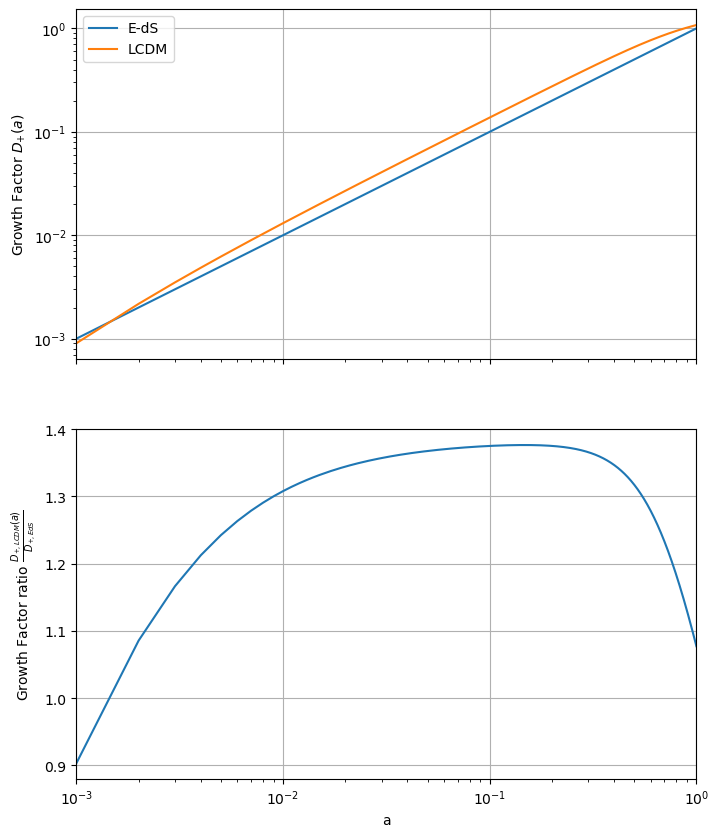

In [6]:
# plot the growth factors and the ratio
fig, ax = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
# create a subplot for the growth factors
plt.xscale("log")
ax[0].loglog(a, D_Eds, label="E-dS")
ax[0].loglog(a, D_LCDM, label="LCDM")
ax[0].set_ylabel(r"Growth Factor $D_{+}(a)$")
ax[0].set_xlim(0.001, 1)
ax[0].set_xscale("log")
ax[0].grid(True)
ax[0].legend()
ax[1].semilogx(a, D_LCDM / D_Eds)
ax[1].set_ylabel(r"Growth Factor ratio $\frac{D_{+,LCDM}(a)}{D_{+,EdS}}$")
ax[1].set_xlim(0.001, 1)
ax[1].set_xscale("log")
ax[1].set_xlabel("a")
ax[1].grid(True)

plt.xscale("log")
plt.savefig("GrowthFactor.png")
plt.show()

# Problem 2 
High redshift galaxies and halo mass functions.

### Plot 1: UV Luminosity Function
Using the Schechter function from Harikane et al. 2022 equation 35, the UV luminosity function is given by
$$ \phi(L) dL= \Phi(M_{UV})dM_{UV} = \frac{\log(10)}{2.5}\phi^* 10^{-0.4(M_{UV} - M_{UV}^*)(\alpha +1)} \exp(-10^{0.4(M_{UV} - M_{UV}^*)})dM_{UV}$$
where $\phi^*$, $M_{UV}^* $, and $\alpha$ are given in table 8 from Harikane et al 2023. Harikane et al gives $M_{UV} \in [-25,-16]$. 

In [7]:
# input the table of data
lumin_params = {}
lumin_params["z=09"] = {"M*": -21.24, "phi*": 10 ** (-4.83), "alpha": -2.35}
lumin_params["z=12"] = {"M*": -20.47, "phi*": 10 ** (-5.06), "alpha": -2.35}
lumin_params["z=16"] = {"M*": -20.80, "phi*": 10 ** (-5.84), "alpha": -2.35}

M_UV = np.linspace(-25, -16, 1000)

In [8]:
# define the schechter function as a function of M_UV
def Schechter(M, M_star, phi_star, alpha):
    c = np.log(10) / 2.5 * phi_star
    b = 10 ** (-0.4 * (alpha + 1) * (M - M_star))
    a = np.exp(-(10 ** (-0.4 * (M - M_star))))
    return c * a * b


# define the schecter function as a function of L/L*
def phi(LoLstar, phi_star, alpha):
    return phi_star * LoLstar ** (alpha + 1) * np.exp(-LoLstar)

Calculate the Schechter function for each redshift to get the luminosity function

In [9]:
redshift = ["z=09", "z=12", "z=16"]
colors = ["blue", "green", "red"]
n_L = {}
# integrate the Schechter function
for i in range(len(redshift)):
    n_L[redshift[i]] = np.zeros(len(M_UV))
    # convert the magnitude to luminosity
    LoLstar = 10 ** (-(M_UV - lumin_params[redshift[i]]["M*"]) / 2.5)
    n_L[redshift[i]] = phi(
        LoLstar, lumin_params[redshift[i]]["phi*"], lumin_params[redshift[i]]["alpha"]
    )

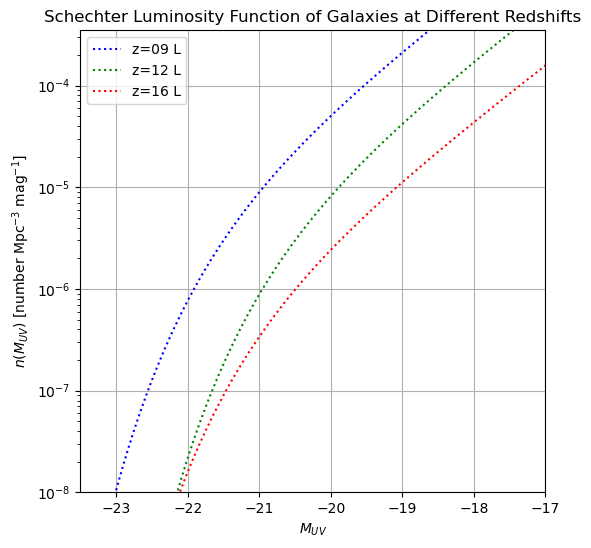

In [10]:
# plot the luminosity function
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(redshift)):
    ax.semilogy(
        M_UV, n_L[redshift[i]], label=redshift[i] + " L", color=colors[i], linestyle=":"
    )
ax.set_title("Schechter Luminosity Function of Galaxies at Different Redshifts")
ax.set_xlabel(r"$M_{UV}$")
ax.set_ylabel(r"$n(M_{UV})$ [number Mpc$^{-3}$ mag$^{-1}$]")
ax.set_ylim(1e-8, 3.5e-4)
ax.set_xlim(-23.5, -17)
ax.legend()
ax.grid(True)
plt.savefig("LuminosityFunction_Phi.png")

### Plot 2: Cumulative luminosity function
The cumulative luminosity function is given by
$$n(<M) = \int_{-\infty}^{M} \Phi(M') dM' = \int_{L}^{\infty} \phi(L) dL$$

In [11]:
# numurically integrate the luminosity function
n_L_cum = {}
for i in range(len(redshift)):
    n_L_cum[redshift[i]] = np.zeros(len(M_UV))
    # convert the magnitude to luminosity
    LoLstar = 10 ** (-(M_UV - lumin_params[redshift[i]]["M*"]) / 2.5)
    for j in range(len(M_UV)):
        # integrate the luminosity function wrt L/L*
        n_L_cum[redshift[i]][j] = integrate.quad(
            phi,
            LoLstar[j],
            np.inf,
            args=(
                lumin_params[redshift[i]]["phi*"],
                lumin_params[redshift[i]]["alpha"],
            ),
        )[0]

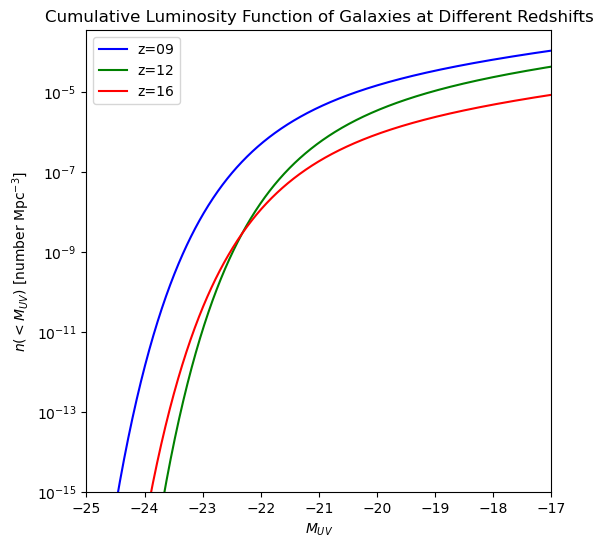

In [12]:
# plot the cumulative luminosity function
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(redshift)):
    ax.semilogy(M_UV, n_L_cum[redshift[i]], label=redshift[i], color=colors[i])
    
ax.set_title("Cumulative Luminosity Function of Galaxies at Different Redshifts")
ax.set_xlabel(r"$M_{UV}$")
ax.set_ylabel(r"$n(<M_{UV})$ [number Mpc$^{-3}$]")
ax.legend()
ax.set_ylim(1e-15, 3.5e-4)
ax.set_xlim(-25, -17)
plt.savefig("LuminosityFunction_Cumulative.png")

### Halo Mass Function for Sheth-Tormen mass function


In [13]:
import hmf

In [14]:
# fit the halo mass function to the calculated cumulative luminosity function
hmf_redshift = {}

hmf_redshift["z=09"] = hmf.MassFunction(z=9, hmf_model="SMT")
hmf_redshift["z=12"] = hmf.MassFunction(z=12, hmf_model="SMT")
hmf_redshift["z=16"] = hmf.MassFunction(z=16, hmf_model="SMT")

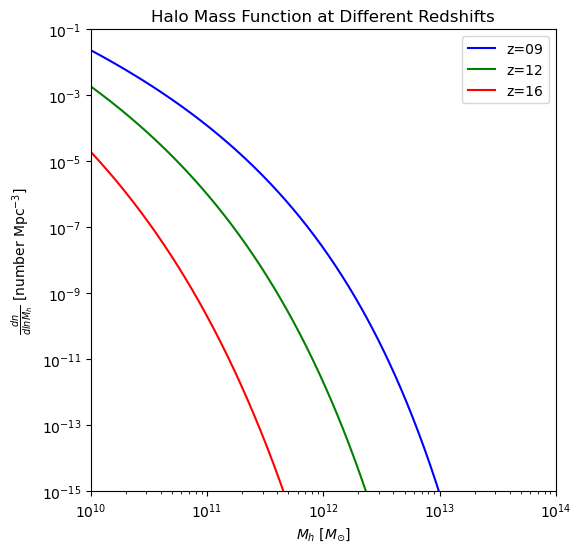

In [15]:
# plot the halo mass function for each redshift
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(redshift)):
    ax.loglog(
        hmf_redshift[redshift[i]].m,
        hmf_redshift[redshift[i]].dndlnm,
        label=redshift[i],
        color=colors[i],
    )
ax.set_title("Halo Mass Function at Different Redshifts")
ax.set_xlabel(r"$M_{h}$ [$M_{\odot}$]")
ax.set_ylabel(r"$\frac{dn}{dlnM_{h}}$ [number Mpc$^{-3}$]")
ax.set_ylim(1e-15, 1e-1)
ax.set_xlim(1e10, 1e14)
ax.legend()
plt.savefig("HaloMassFunction.png")
plt.show()

### Magnitude to Halo Mass

Max difference between the cumulative luminosity function and the halo mass function at z=09 is 5.038272925437609e-06 Mpc^-3
Max difference between the cumulative luminosity function and the halo mass function at z=12 is 2.5639072987372754e-06 Mpc^-3
Max difference between the cumulative luminosity function and the halo mass function at z=16 is 5.641694484319484e-07 Mpc^-3


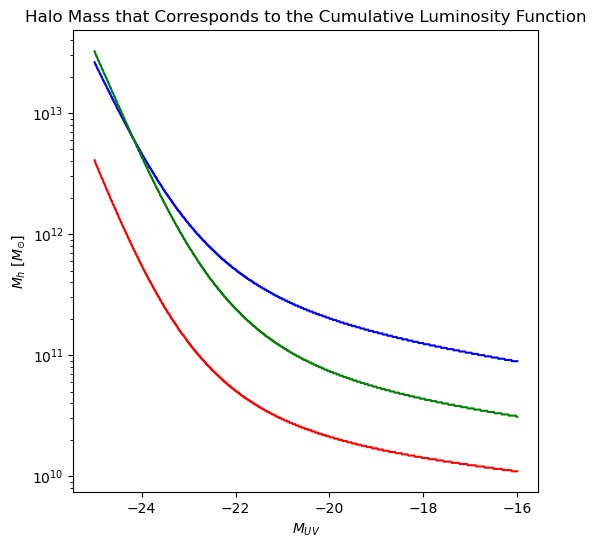

In [16]:
# find the halo mass that corresponds to the cumulative luminosity function
M_h = {}
M_h["z=09"] = np.zeros(len(M_UV))
M_h["z=12"] = np.zeros(len(M_UV))
M_h["z=16"] = np.zeros(len(M_UV))

for i in range(len(redshift)):
    min_diff = np.zeros(len(M_UV))
    for j in range(len(M_UV)):
        # find the index of the halo mass that is closest to the cumulative luminosity function
        ind = np.argmin(
            np.abs(hmf_redshift[redshift[i]].dndlnm - n_L_cum[redshift[i]][j])
        )
        min_diff[j] = np.min(
            np.abs(hmf_redshift[redshift[i]].dndlnm - n_L_cum[redshift[i]][j])
        )
        # store the halo mass that corresponds to the cumulative luminosity function
        M_h[redshift[i]][j] = hmf_redshift[redshift[i]].m[ind]
    # double check the the maximum difference is small
    print(
        f"Max difference between the cumulative luminosity function and the halo mass function at {redshift[i]} is {np.max(min_diff)} Mpc^-3"
    )

# plot the halo mass that corresponds to the cumulative luminosity function
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for i in range(len(redshift)):
    ax.semilogy(M_UV, M_h[redshift[i]], label=redshift[i], color=colors[i])
ax.set_title("Halo Mass that Corresponds to the Cumulative Luminosity Function")
ax.set_xlabel(r"$M_{UV}$")
ax.set_ylabel(r"$M_{h}$ [$M_{\odot}$]")
plt.savefig("HaloMassvsMagnitude.png")
plt.show()